# MNIST with PyTorch

In [2]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
%matplotlib inline

num_samples = 1000
max_iter = 100

## Load and Understand the Data

First, let's load the MNIST dataset. Each image is a 28x28 grid of grayscale pixels.

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Shape of one image: (28, 28)


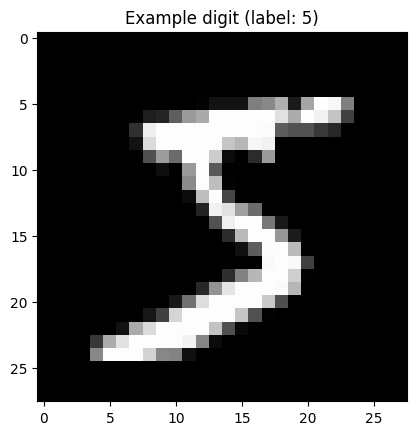

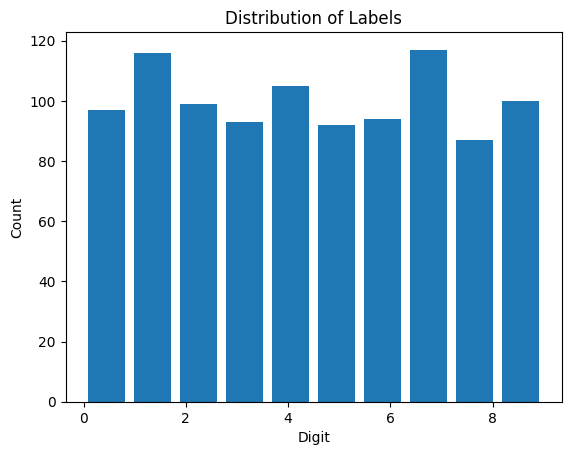

In [4]:
# Load a subset of MNIST to start
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
x_full = mnist.data[:num_samples] / 255.0  # Scale pixel values to [0,1]
x_full = x_full.astype('float32')
y_full = mnist.target[:num_samples].astype(int)

# Look at the shape of one image
single_image = x_full[0].reshape(28, 28)  # Reshape back to 2D
plt.imshow(single_image, cmap='gray')
plt.title(f"Example digit (label: {y_full[0]})")
print("Shape of one image:", single_image.shape)

# Look at the distribution of labels
plt.figure()
plt.hist(y_full, bins=10, rwidth=0.8)
plt.title("Distribution of Labels")
plt.xlabel("Digit")
plt.ylabel("Count");

### Understanding Flattening

To use these images in our model, we need to "flatten" each 28x28 grid into a single vector of 784 numbers:

Shape after flattening: (784,)


Text(0, 0.5, 'Pixel value')

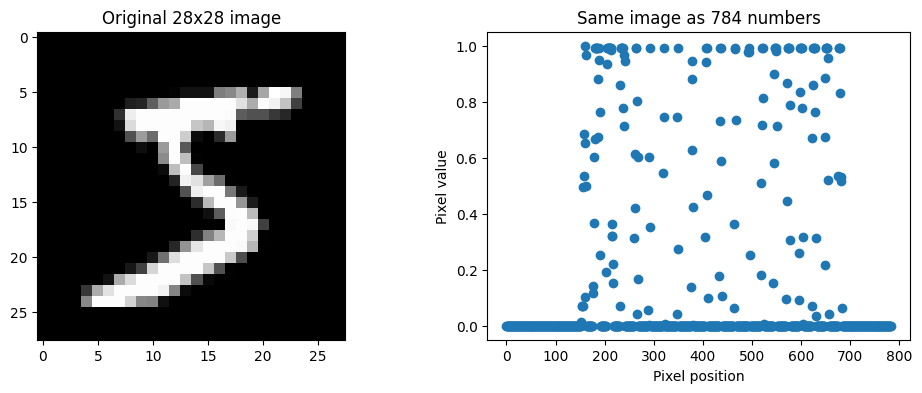

In [6]:
# Demonstrate flattening on one image
flat_image = single_image.reshape(-1)  # -1 means "figure out this dimension"
print("Shape after flattening:", flat_image.shape)

# Visualize how flattening works
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.imshow(single_image, cmap='gray')
ax1.set_title("Original 28x28 image")
ax2.scatter(np.arange(784), flat_image)
ax2.set_title("Same image as 784 numbers")
ax2.set_xlabel("Pixel position")
ax2.set_ylabel("Pixel value")

Our dataset `x_full` was already flattened: each row is one flattened image:

In [7]:
print("Full dataset shape:", x_full.shape)
print("Number of training examples:", x_full.shape[0])
print("Number of features per example:", x_full.shape[1])

Full dataset shape: (1000, 784)
Number of training examples: 1000
Number of features per example: 784


### Setting up data loaders

We'll split the data into training and validation sets, and set up PyTorch `DataLoader` objects to feed the data to our model.

In [8]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_full, y_full, test_size=0.2, random_state=42)

# Create DataLoader objects
train_data = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
val_data = TensorDataset(torch.tensor(x_val), torch.tensor(y_val))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

## Train an MLP to classify MNIST

We'll use PyTorch to train a simple multi-layer perceptron (MLP) to classify MNIST digits.

You should be able to piece this together from what we've done before!

Epoch 0: val_loss = 1.558
Epoch 1: val_loss = 0.932
Epoch 2: val_loss = 0.703
Epoch 3: val_loss = 0.599
Epoch 4: val_loss = 0.544
Epoch 5: val_loss = 0.503
Epoch 6: val_loss = 0.492
Epoch 7: val_loss = 0.520
Epoch 8: val_loss = 0.484
Epoch 9: val_loss = 0.474
Epoch 10: val_loss = 0.479
Epoch 11: val_loss = 0.473
Epoch 12: val_loss = 0.462
Epoch 13: val_loss = 0.471
Epoch 14: val_loss = 0.479
Epoch 15: val_loss = 0.479
Epoch 16: val_loss = 0.476
Epoch 17: val_loss = 0.466
Epoch 18: val_loss = 0.498
Epoch 19: val_loss = 0.505
Epoch 20: val_loss = 0.500
Epoch 21: val_loss = 0.493
Epoch 22: val_loss = 0.503
Epoch 23: val_loss = 0.505
Epoch 24: val_loss = 0.504
Epoch 25: val_loss = 0.518
Epoch 26: val_loss = 0.506
Epoch 27: val_loss = 0.518
Epoch 28: val_loss = 0.528
Epoch 29: val_loss = 0.542
Epoch 30: val_loss = 0.531
Epoch 31: val_loss = 0.530
Epoch 32: val_loss = 0.535
Epoch 33: val_loss = 0.542
Epoch 34: val_loss = 0.537
Epoch 35: val_loss = 0.535
Epoch 36: val_loss = 0.546
Epoch 37: v

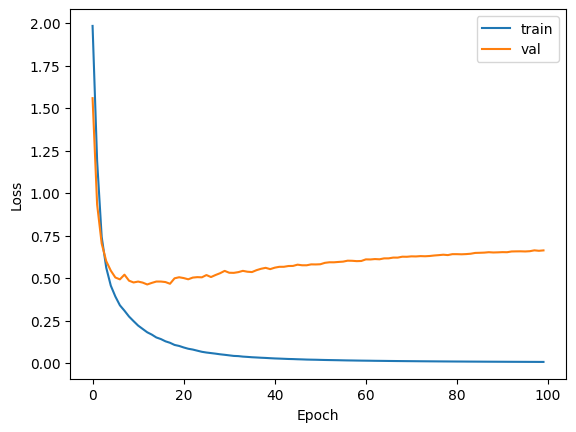

In [27]:
# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.linear_1 = nn.Linear(in_features=input_size, out_features=hidden_size, bias=True)
        self.linear_2 = nn.Linear(in_features=hidden_size, out_features=num_classes, bias=True)

    def forward(self, x):
        z1 = self.linear_1(x) # does the forward pass internally (weights and bias included)
        # internally, this is doing
        a1 = torch.relu(z1)
        logits = self.linear_2(a1)
        return logits

# Instantiate the model
input_size = 784
hidden_size = 512 # 2^9
num_classes = 10  # 10 numbers

model = MLP(input_size, hidden_size, num_classes)
learning_rate = 0.1

# Train the model
train_losses = []
val_losses = []

for epoch in range(max_iter):
    train_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Forward pass
        logits = model.forward(x_batch)
        # Compute the loss (remember that F.cross_entropy does the softmax internally)
        loss = F.cross_entropy(logits, y_batch)

        train_loss += loss.item()

        # Backward pass
        # Clear old gradients
        model.zero_grad()
        # Compute the gradients
        loss.backward()
        # Update the weights
        for param in model.parameters():
            param.data -= learning_rate * param.grad
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Compute validation loss
    with torch.no_grad(): # Don't compute gradients, since we're not updating the model
        val_loss = 0.
        for x_val_batch, y_val_batch in val_loader:
            logits = model.forward(x_val_batch)
            val_loss += F.cross_entropy(logits, y_val_batch)
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
    print(f"Epoch {epoch}: val_loss = {val_loss:.3f}")

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Data Augmentation

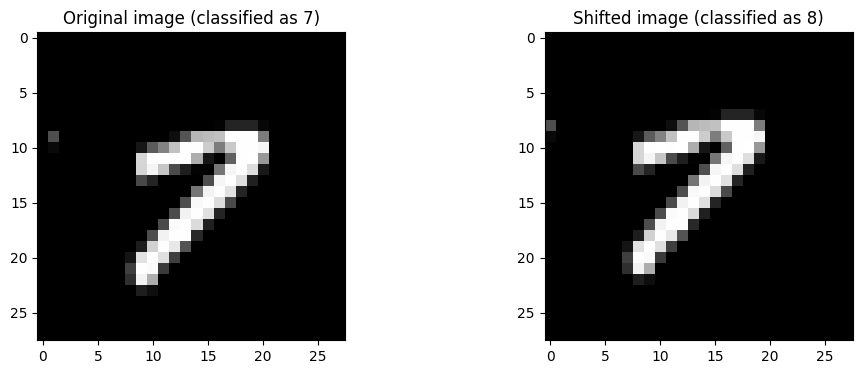

In [28]:
# Shifting the image by one pixel shouldn't make a difference, right?
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = torch.roll(image, shifts=(dy, dx), dims=(0, 1))
    return shifted_image.reshape(-1)

def shift_images(image_batch, dx, dy):
    n_batch = image_batch.shape[0]
    return torch.roll(image_batch.reshape(n_batch, 28, 28), shifts=(dy, dx), dims=(1, 2)).reshape(n_batch, 784)

def classify(model, x):
    with torch.no_grad():
        logits = model(x)
        return logits.argmax(dim=-1)

# Visualize the shifted image
single_image = torch.tensor(x_train)[0]
shifted_image = shift_image(single_image, -1, -1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.imshow(single_image.reshape(28, 28), cmap='gray')
ax1.set_title(f"Original image (classified as {classify(model, single_image)})")
ax2.imshow(shifted_image.reshape(28, 28), cmap='gray')
ax2.set_title(f"Shifted image (classified as {classify(model, shifted_image)})");


Solution: shift the images while we're training!

Epoch 0: val_loss = 1.680
Epoch 1: val_loss = 1.114
Epoch 2: val_loss = 0.848
Epoch 3: val_loss = 0.664
Epoch 4: val_loss = 0.604
Epoch 5: val_loss = 0.564
Epoch 6: val_loss = 0.517
Epoch 7: val_loss = 0.493
Epoch 8: val_loss = 0.463
Epoch 9: val_loss = 0.466
Epoch 10: val_loss = 0.442
Epoch 11: val_loss = 0.428
Epoch 12: val_loss = 0.417
Epoch 13: val_loss = 0.411
Epoch 14: val_loss = 0.411
Epoch 15: val_loss = 0.433
Epoch 16: val_loss = 0.409
Epoch 17: val_loss = 0.405
Epoch 18: val_loss = 0.390
Epoch 19: val_loss = 0.436
Epoch 20: val_loss = 0.435
Epoch 21: val_loss = 0.416
Epoch 22: val_loss = 0.391
Epoch 23: val_loss = 0.375
Epoch 24: val_loss = 0.398
Epoch 25: val_loss = 0.378
Epoch 26: val_loss = 0.378
Epoch 27: val_loss = 0.409
Epoch 28: val_loss = 0.383
Epoch 29: val_loss = 0.362
Epoch 30: val_loss = 0.367
Epoch 31: val_loss = 0.377
Epoch 32: val_loss = 0.355
Epoch 33: val_loss = 0.372
Epoch 34: val_loss = 0.337
Epoch 35: val_loss = 0.352
Epoch 36: val_loss = 0.328
Epoch 37: v

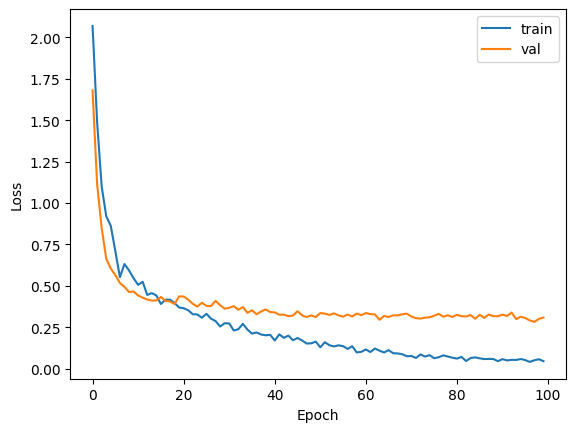

In [30]:

model = MLP(input_size, hidden_size, num_classes)
learning_rate = 0.1

# Training loop!
train_losses = []
val_losses = []

for epoch in range(max_iter):
    train_loss = 0.
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Apply random shifts to the images. Pick a shift for this batch.
        shift_x = torch.randint(-1, 2, size=(1,))
        shift_y = torch.randint(-1, 2, size=(1,))
        x_batch_shifted = shift_images(x_batch, shift_x, shift_y)

        # Forward pass
        logits = model.forward(x_batch_shifted)
        # Compute the loss
        loss = F.cross_entropy(logits, y_batch)

        train_loss += loss.item()

        # Backward pass
        # Clear old gradients
        model.zero_grad()
        # Compute the gradients
        loss.backward()
        # Update the weights
        for param in model.parameters():
            param.data -= learning_rate * param.grad
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Compute validation loss
    with torch.no_grad():
        val_loss = 0.
        for x_val_batch, y_val_batch in val_loader:
            logits = model.forward(x_val_batch)
            val_loss += F.cross_entropy(logits, y_val_batch)
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
    print(f"Epoch {epoch}: val_loss = {val_loss:.3f}")

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()